In [1]:
#  *** 1 *** SQL query pro tahani PARCEL 
query_pozemky = """



WITH
-- 1) CTE pro validní záznamy typu 'parcela' bez chyby v GPS_API_info
ValidValuo AS (
    SELECT
        V.*
    FROM
        dbo.Valuo_data AS V
    WHERE
        V.nemovitost = 'parcela'
        AND NOT EXISTS (
            SELECT 1
            FROM dbo.Valuo_data AS V2
            WHERE
                V2.cislo_vkladu = V.cislo_vkladu
                AND (
                    V2.nemovitost <> 'parcela'
                    OR V2.GPS_API_info = 'ERR'
                )
        )
),

-- 2) CTE, které pro každý cislo_vkladu vypočítá celkovou plochu všech parcel
SumArea AS (
    SELECT
        cislo_vkladu,
        SUM(plocha) AS SUM_PLOCHA
    FROM
        ValidValuo
    GROUP BY
        cislo_vkladu
),

-- 3) CTE, které spočítá počet DISTINCT adres (parcel) pro každý cislo_vkladu
ParcelCounts AS (
    SELECT
        V.cislo_vkladu,
        COUNT(DISTINCT V.adresa) AS ParcelCount
    FROM
        ValidValuo AS V
        LEFT JOIN dbo.KN_parcel_data AS K
            ON K.id_valuo = V.id
    GROUP BY
        V.cislo_vkladu
)

-- 4) Hlavní SELECT – ke „validním“ záznamům připojíme SUM_PLOCHA, ParcelCount a další tabulky
SELECT
    V.id                           AS id_valuo,
    U.id                           AS id_up,
    V.cislo_vkladu,
    V.rok,
    V.mesic,
    V.datum_podani,
    V.listina,
    PC.ParcelCount                  AS [#PARCEL],
    SA.SUM_PLOCHA                   AS SUM_PARCEL_RIZENI,
    V.okres,
    V.kat_uzemi                     AS KU_Valuo,
    K.zoning_title                  AS KU_KN,
    K.upper_zoning_id,               --AS kod_ku,
    K.administrativeUnit_title      AS lokalita,
    V.nemovitost,
    --U.*,
    U.POPIS_Z,
	V.typ,
    K.parcel_number,
    V.plocha,
    V.cenovy_udaj,
    -- Výpočet průměrné jednotkové ceny (zaokrouhlené) bez window funkcí:
    CAST(
      ROUND(
        V.cenovy_udaj 
        / NULLIF(SA.SUM_PLOCHA, 0),
        0
      ) 
      AS DECIMAL(38,0)
    )                               AS JC,
    K.gml_id,
    K.areaValue_m2,
    K.beginLifespanVersion,
    K.endLifespanVersion,
    K.geometry,
    K.inspire_localId,
    K.inspire_namespace,
    K.label,
    K.nationalCadastralReference,
    K.refPoint_x,
    K.refPoint_y,
    K.refPoint_lon,
    K.refPoint_lat,
    K.validFrom,
    K.administrativeUnit_href,
    K.administrativeUnit_title     AS adminUnitTitle,
    K.zoning_href,
    K.zoning_title                  AS zoningTitleUP,
    K.id_valuo,
    K.id_UP_FVU_data
FROM
    ValidValuo AS V

    INNER JOIN SumArea AS SA
        ON SA.cislo_vkladu = V.cislo_vkladu

    LEFT JOIN ParcelCounts AS PC
        ON PC.cislo_vkladu = V.cislo_vkladu

    LEFT JOIN dbo.KN_parcel_data AS K
        ON K.id_valuo = V.id

    LEFT JOIN dbo.UP_FVU_data AS U
        ON U.id = K.id_UP_FVU_data

WHERE 1=1
    -- Filtrujeme pouze záznamy, kde průměrná jednotková cena > 0:
    AND CAST(
      ROUND(
        V.cenovy_udaj 
        / NULLIF(SA.SUM_PLOCHA, 0),
        0
      ) 
      AS DECIMAL(38,0)
    ) > 999        -- Průměrná jednotková cena musí být větší než 

    AND CAST(
      ROUND(
        V.cenovy_udaj 
        / NULLIF(SA.SUM_PLOCHA, 0),
        0
      ) 
      AS DECIMAL(38,0)
    ) < 10000       -- A zároveň menší než 

    
    AND upper_zoning_id IS NOT NULL
    --AND listina like ('Smlouva kupní')
    --AND plocha > 49
    --AND plocha < 2000

    
    --AND V.okres = 'Děčín'
    
    
    AND V.kat_uzemi in ('Ládví', 'Těptín', 'Štiřín', 'Kamenice', 'Pyšely', 'Sulice')


	--AND V.kat_uzemi in ('Písnice', 'Kunratice', 'Libuš', 'Krč')
  
  /*  
    AND (
           U.POPIS_Z LIKE '%DH%'        -- veřejná doprava
        OR U.POPIS_Z LIKE '%DZ%'        -- tratě / dráhy
        OR U.POPIS_Z LIKE '%OP%'        -- orná půda
        OR U.POPIS_Z LIKE '%ZMK%'       -- zeleň městská
        OR U.POPIS_Z LIKE '%ZP%'        -- zeleň přírodní, parky
        OR U.POPIS_Z LIKE '%PS%'        -- sady, zahrady, vinice
        OR U.POPIS_Z LIKE '%LR%'        -- lesní porosty
        OR U.POPIS_Z LIKE '%NL%'        -- louky a pastviny     
        OR U.POPIS_Z LIKE '%IZ%'        -- izolační zeleň
        OR U.POPIS_Z LIKE 'S[0-9]'      -- silnice / komunikace
        OR U.POPIS_Z LIKE '%VN%'        -- výroba nerušící
        OR U.POPIS_Z LIKE '%VOP%'       -- vodní toky a plochy
        OR U.POPIS_Z LIKE '%VV%'        -- veřejné vybavení
        OR U.POPIS_Z LIKE '%OV%'        -- všeobecně smíšené

    );
    
*/




"""

C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\2531498409.py:326: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregate_popup_pozemky)
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\2531498409.py:367: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_p_agg.geometry.centroid.y.mean(),
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\2531498409.py:368: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_p_ag


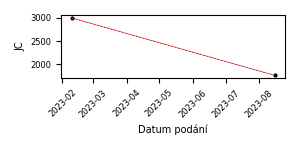
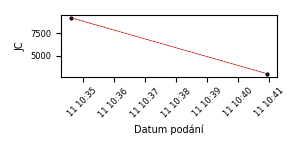
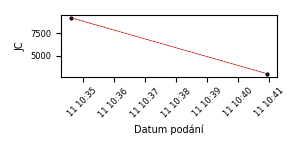
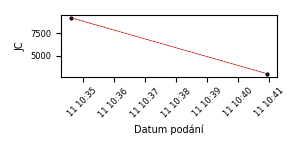
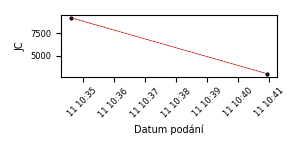
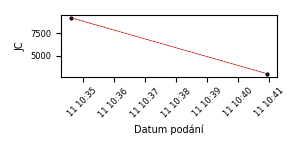
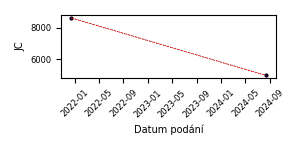

In [2]:
# *** 2 *** MAPA


import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import folium
from folium import Map
from folium.elements import MacroElement
from folium.raster_layers import WmsTileLayer

from typing import Union

import logging
import urllib.parse
from sqlalchemy import create_engine

from jinja2 import Template
import webbrowser

from shapely.geometry import Polygon
from shapely.errors import TopologicalError

import io
import base64
import matplotlib.pyplot as plt

# ==============================================================================
# 1) Logging
# ==============================================================================
logger = logging.getLogger("ParcelViz")
logger.setLevel(logging.DEBUG)
fmt = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch = logging.StreamHandler();   ch.setLevel(logging.INFO);  ch.setFormatter(fmt);  logger.addHandler(ch)
fh = logging.FileHandler("process_log.txt", encoding="utf-8"); fh.setLevel(logging.DEBUG); fh.setFormatter(fmt); logger.addHandler(fh)

# ==============================================================================
# 2) Konstanty
# ==============================================================================
EXCHANGE_RATE_EUR_CZK = 25.0

# ==============================================================================
# 3) Pomocné funkce
# ==============================================================================

""" def parse_geometry(geom_str):
    try:
        coords = list(map(float, geom_str.split()))
        return Polygon([(coords[i], coords[i+1]) for i in range(0, len(coords), 2)])
    except Exception as e:
        logger.error(f"Chyba při převodu geometrie: {e}")
        return None """

def parse_geometry(geom_str):
    """
    Parsuje řetězec souřadnic na shapely.geometry.Polygon.
    - Pokud je vstup None/NaN nebo se objeví jakákoliv chyba,
      zaloguje ji a vrátí None.
    """
    # pokud je geom_str None (nebo v pandas NaN), rovnou skončíme
    if geom_str is None:
        logger.debug("Empty geometry string, returning None")
        return None

    try:
        coords = list(map(float, geom_str.split()))
        poly = Polygon([(coords[i], coords[i+1]) 
                        for i in range(0, len(coords), 2)])
        return poly

    except ValueError as e:
        logger.error(f"Non-numeric coordinate in geometry '{geom_str}': {e}")
        return None

    except IndexError as e:
        logger.error(
            f"Odd number of coordinate values in '{geom_str}', "
            "expected pairs of (x, y)."
        )
        return None

    except TopologicalError as e:
        logger.error(f"Invalid polygon topology for '{geom_str}': {e}")
        return None

    except Exception as e:
        # poslední pojistka pro neočekávané chyby
        logger.error(f"Chyba při převodu geometrie '{geom_str}': {e}")
        return None

#def format_thousand_space(val):
#    try:
#        return f"{float(val):,.0f}".replace(",", " ")
#    except:
#        return str(val)

def format_datum_podani(datum_str):
    """
    Převede datum 'YYYY-MM-DD HH:MM:SS.sss' na formát:
    MĚSÍC/ROK, (původní celý datum/časový údaj).
    Např. '2024-12-02 13:17:27.000' -> '<strong>12/2024</strong>, (2024-12-02 13:17:27.000)'
    Pokud parsování selže, vrátí původní řetězec.
    """
    try:
        dt_parsed = pd.to_datetime(datum_str)
        month_year = dt_parsed.strftime("%m/%Y")
        return f"<strong>{month_year}</strong>, ({datum_str})"
    except:
        return datum_str


def format_thousand_space(val, decimals: int = 2) -> str:
    """
    Formátuje číslo s mezerami jako oddělovači tisíců
    a čárkou jako desetinou čárkou.

    - Pro celočíselné hodnoty (např. 10560.0) vrátí "10 560"
    - Pro hodnoty s desetinnou částí (např. 56.39) vrátí "56,39"
      (vždy s přesně `decimals` místy za čárkou)
    """
    try:
        fval = float(val)
    except (ValueError, TypeError):
        # pokud se to nepovede převést na float, vrať původní řetězec
        return str(val)

    # celočíselné
    if fval.is_integer():
        # int(fval) odstraní .0 a f"{:,}" vloží čárky pro tisíce
        s = f"{int(fval):,}"
        # čárky jako tisícové oddělovače zaměníme za mezery
        return s.replace(",", " ")

    # má desetinnou část → formátujeme s pevnými `decimals` místy
    # f"{fval:,.2f}" => "1,234.56" nebo "56.39"
    s = f"{fval:,.{decimals}f}"
    # čárky pro tisíce → mezery, tečku desetinnou → čárka
    return s.replace(",", " ").replace(".", ",")


# ========================================================================
# Upravená funkce pro pozemky 
# ========================================================================
def aggregate_popup_pozemky(g):
    """
    Vytvoří HTML pro popup u POZEMKŮ:
    - seřadí řízení sestupně podle datum_podání,
    - vykreslí scrollovatelný blok s informacemi,
    - pokud je více než jedno řízení, doplní pod něj malý graf datum vs. JC,
    - dole vypíše průměrnou JC, počet řízení a odkaz na katastr.
    """
    import io, base64
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.dates as mdates

    first = g.iloc[0]
    entries = []
    jc_values = []
    computed = []

    # 1) Sestavíme seznam (cislo_vkladu, datum_podani, JC, subdf)
    for cislo, subdf in g.groupby('cislo_vkladu'):
        row = subdf.iloc[0]
        datum_raw = pd.to_datetime(row['datum_podani'])
        jc_val = float(row.get('JC') or 0)
        if row.get('mena') == 'EUR':
            jc_val *= EXCHANGE_RATE_EUR_CZK
        jc_values.append(jc_val)
        computed.append((cislo, datum_raw, jc_val, subdf))

    # 2) Seřadíme sestupně podle data podání
    computed.sort(key=lambda x: x[1], reverse=True)

    # 3) Vygenerujeme HTML tabulky
    for cislo, datum_raw, jc_val, subdf in computed:
        row = subdf.iloc[0]
        datum = format_datum_podani(row['datum_podani'])
        okres = row['okres']
        kat_u_valuo = row['KU_Valuo']
        kat_u_KN = row['lokalita']
        zoning_id = row['upper_zoning_id']
        typ = row['typ']
        parc_no = row['parcel_number']
        pocet = int(row['#PARCEL'])
        UP_FVU = row['POPIS_Z']

        plocha_ind_s   = format_thousand_space(row['plocha'], 0)
        plocha_total_s = format_thousand_space(row['SUM_PARCEL_RIZENI'], 0)

        cu_orig = float(row.get('cenovy_udaj') or 0)
        if row.get('mena') == 'EUR':
            cu_disp = (
                f"{format_thousand_space(cu_orig,0)} EUR / "
                f"{format_thousand_space(cu_orig*EXCHANGE_RATE_EUR_CZK,0)} CZK"
            )
        else:
            cu_disp = f"{format_thousand_space(cu_orig,0)} CZK"

        jc_str = f"{format_thousand_space(jc_val,0)} CZK/m²"

        entries.append(f"""
            <table style="font-size:10px; margin-bottom:8px;">
              <tr><td colspan="2">
                <hr style="border-top:2px solid #007bff; margin:4px 0;">
              </td></tr>
              <tr><td><strong>Č. vkladu:</strong></td><td>{cislo}</td></tr>
              <tr><td><strong>Datum podání:</strong></td><td>{datum}</td></tr>
              <tr><td><strong>Počet parcel v rámci řízení:</strong></td><td>{pocet}</td></tr>
              <tr><td><strong style="color: green;">Celková plocha parcel v rámci řízení:</strong></td>
                  <td style="color: green;"><b>{plocha_total_s} m²</b></td></tr>
              <tr><td><strong style="color: green;">Plocha parcely:</strong></td>
                  <td style="color: green;">{plocha_ind_s} m²</td></tr>
              <tr><td><strong style="color: blue;">Cenový údaj:</strong></td>
                  <td style="color: blue;">{cu_disp}</td></tr>
              <tr><td><strong style="color: blue; font-size:12px;">JC (prům.) na řízení:</strong></td>
                  <td style="color: blue; font-size:12px;"><b>{jc_str}</b></td></tr>
              <tr><td><strong>Okres:</strong></td><td>{okres}</td></tr>
              <tr><td><strong>Kat.území (dle Valuo):</strong></td><td>{kat_u_valuo}</td></tr>
              <tr><td><strong>Kat.území (dle KN):</strong></td><td>{kat_u_KN}</td></tr>
              <tr><td><strong>Kód kat.území:</strong></td><td>{zoning_id}</td></tr>
              <tr><td><strong>Typ parcely:</strong></td><td>{typ}</td></tr>
              <tr><td><strong>Parc.č.:</strong></td><td>{parc_no}</td></tr>

              <tr><td><strong>Uzemní plán - FVU:</strong></td><td>{UP_FVU}</td></tr>
            </table>
        """)

    # 4) Scrollovatelný kontejner
    scroll_div = (
        '<div style="max-height:300px; max-width:300px; overflow-y:auto; padding-right:4px;">'
        + "".join(entries) +
        '</div>'
    )

    # 5) Graf datum vs. JC, pokud je >1 řízení
    chart_html = ""
    if len(computed) > 1:
        dates = [t[1] for t in computed]
        jcs   = [t[2] for t in computed]
        fig, ax = plt.subplots(figsize=(3, 1.5))
        #ax.bar(dates, jcs, width=2)

        # čárový graf s markery různých parametrů
        ax.plot(
            dates,
            jcs,
            marker='o',
            linestyle=':',
            markersize=2,           # velikost markeru
            markerfacecolor='blue',  # výplň markeru
            markeredgecolor='black',# okraj markeru
            color='black',           # barva čáry
            linewidth=0.5             # tloušťka čáry
        )
        # 1) Převod dat na číselné hodnoty pro fit (ordinal)
        x = mdates.date2num(dates)
        y = np.array(jcs)

        # 2) Fit přímky (stupeň 1)
        coef = np.polyfit(x, y, 1)      # [slope, intercept]
        poly1d_fn = np.poly1d(coef)

        # 3) Vykreslení trendové čáry
        # rozmezí od min do max data
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(
            mdates.num2date(x_line),
            poly1d_fn(x_line),
            color='red',
            linestyle='--',
            linewidth=0.5,
            label='Trendová čára'
        )

        ax.set_xlabel("Datum podání", fontsize=7)
        ax.set_ylabel("JC",  fontsize=7)
        ax.tick_params(axis='x', rotation=45, labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        fig.tight_layout()
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        plt.close(fig)
        data = base64.b64encode(buf.getvalue()).decode('ascii')
        chart_html = f'''
            <div style="text-align:center; margin:8px 0;">
              <img src="data:image/png;base64,{data}"
                   style="width:100%; height:auto; max-width:300px;"/>
            </div>
        '''

    # 6) Footer: průměrná JC, počet řízení a odkaz
    avg_jc    = sum(jc_values) / len(jc_values) if jc_values else 0.0
    avg_html  = f"<p><strong>Průměrná JC parcely:</strong><b> {format_thousand_space(avg_jc,0)} CZK/m²</b></p>"
    count_html= f"<p><strong>Počet řízení:</strong> {len(computed)}</p>"
    parcel_q  = urllib.parse.quote_plus(first['parcel_number'])
    ku_q      = urllib.parse.quote_plus(str(first['upper_zoning_id']))
    link_html = (
        f'<p><a href="https://nahlizenidokn.cuzk.cz/VyberParcelu/Parcela/InformaceO'
        f'?cisloParcelni={parcel_q}&katastralniUzemi={ku_q}" target="_blank">'
        "Otevřít hledání na katastru</a></p>"
    )

    return scroll_div + chart_html + avg_html + count_html + link_html


# ==============================================================================
# 5) Připojení k databázi
# ==============================================================================
conn = urllib.parse.quote_plus(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;Database=VALUO;Trusted_Connection=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn}")

# ==============================================================================
# 6) Načtení a příprava dat – POZEMKY
# ==============================================================================
df_p = pd.read_sql(query_pozemky, engine)
df_p['geometry'] = df_p['geometry'].apply(parse_geometry)
gdf_p = gpd.GeoDataFrame(df_p, geometry='geometry', crs="EPSG:5514").to_crs(epsg=4326)

popup_p = (df_p
           .groupby(['upper_zoning_id','parcel_number'])   # grupovaní podle kombinace katastralni uzemí a parcelního čísla = jedinecny identifikator
           .apply(aggregate_popup_pozemky)
           .reset_index(name='popup_html'))

gdf_p_agg = (gdf_p
           .dissolve(by=['upper_zoning_id','parcel_number'], as_index=False)
           .merge(popup_p, on=['upper_zoning_id','parcel_number'], how='left'))
# zachováme jen geometry, JC a popup_html
gdf_p_agg = gdf_p_agg[['geometry','JC','popup_html']]



# ==============================================================================
# 8) Funkce pro barvy
# ==============================================================================
def get_color_pozemky(jc):
    # vaše původní škála
    if jc <= 10:      return "#001200"
    elif jc <= 99:    return "#014701"
    elif jc <= 249:   return "#2B7203"
    elif jc <= 499:   return "#4CC705"
    elif jc <= 999:   return "#82DA06"
    elif jc <= 2999:  return "#B5D00A"
    elif jc <= 4999:  return "#E6DB0C"
    elif jc <= 9999:  return "#E8C30A"
    elif jc <= 14999: return "#E3B008"
    elif jc <= 19999: return "#EF9E06"
    elif jc <= 29999: return "#AC6207"
    elif jc <= 39999: return "#D35F07"
    elif jc <= 59999: return "#C32E04"
    else:             return "#F11909"


def style_poz(feature):
    jc = float(feature['properties'].get('JC') or 0)
    return {'color':'black','weight':2,'fillColor':get_color_pozemky(jc),'fillOpacity':0.5}


# ==============================================================================
# 9) Vytvoření mapy
# ==============================================================================
center = [
    gdf_p_agg.geometry.centroid.y.mean(),
    gdf_p_agg.geometry.centroid.x.mean()
]
m = folium.Map(location=center, zoom_start=15, tiles=None)

# základní dlaždice
# Přidání defaultních TileLayerů Folia pro přepínání
# základní OSM

folium.TileLayer(
    tiles='OpenStreetMap',
    name='Open Street Map',
    attr='© OpenStreetMap contributors',
    show=True       # tato bude výchozí
).add_to(m)

# Turisticka mapa
folium.TileLayer(
    tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    name='Open Topo Map',
    attr='© OpenTopoMap (CC-BY-SA)',
    overlay=False,    # základní dlaždice
    show=False
).add_to(m)


# CartoDB Positron
folium.TileLayer(
    tiles='https://cartodb-basemaps-a.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png',
    name='CartoDB LIGHT',
    attr='© OpenStreetMap contributors © CARTO',
    show=False      # bude vypnutá
).add_to(m)

# CartoDB Dark Matter
folium.TileLayer(
    tiles='https://cartodb-basemaps-a.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png',
    name='CartoDB DARK',
    attr='© OpenStreetMap contributors © CARTO',
    show=False      # bude vypnutá
).add_to(m)



folium.TileLayer(
    tiles=(
        'https://ags.cuzk.gov.cz/arcgis1/rest/services/'
        'ORTOFOTO_WM/MapServer/tile/{z}/{y}/{x}'
    ),
    name='Ortofotomapa ČÚZK',
    attr='© ČÚZK',
    overlay=False,
    control=True,
    show=False  # změňte na True, pokud chcete vrstvu zapnout hned
).add_to(m)


# Ortofoto
folium.TileLayer(
    tiles='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    name='Ortofotomapa ESRI',
    attr='Esri World Imagery',
    overlay=False,
    control=True,
    show=False      # bude vypnutá
).add_to(m)

# Hranice parcel se budou nabízet až od zoomu 15 do 19
WmsTileLayer(
    url='https://services.cuzk.gov.cz/wms/local-km-wms.asp?',
    name='Hranice parcel',
    layers='hranice_parcel',
    fmt='image/png',
    transparent=True,
    version='1.3.0',
    attr='© ČÚZK',
    overlay=True,
    control=True,
    show=False,
    minZoom=0,
    maxZoom=30
).add_to(m)

# Parcelní čísla od zoomu 16 (až budou dost čitelné)
WmsTileLayer(
    url='https://services.cuzk.gov.cz/wms/local-km-wms.asp?',
    name='Parcelní čísla',
    layers='parcelni_cisla',
    fmt='image/png',
    transparent=True,
    version='1.3.0',
    attr='© ČÚZK',
    overlay=True,
    control=True,
    show=False,
    minZoom=0,
    maxZoom=30
).add_to(m)

# Základní Katastrální mapa (KN) necháme viditelnou od zoomu 0
WmsTileLayer(
    url='https://services.cuzk.gov.cz/wms/local-km-wms.asp?',
    name='Katastrální mapa (KN)',
    layers='KN',
    fmt='image/png',
    transparent=True,
    version='1.3.0',
    attr='© ČÚZK',
    overlay=True,
    control=True,
    show=False,
    minZoom=0,
    maxZoom=30
).add_to(m)


# Dynamická vrstva ÚP
class DynamicArcGISTileLayer(MacroElement):
    _template = Template(u"""
        {% macro script(this, kwargs) %}
            var DynamicLayer = L.TileLayer.extend({
                getTileUrl: function(coords) {
                    var tileSize = 256;
                    var initialResolution = 2 * Math.PI * 6378137 / tileSize;
                    var originShift = 2 * Math.PI * 6378137 / 2.0;
                    var resolution = initialResolution / Math.pow(2, coords.z);
                    var minx = coords.x * tileSize * resolution - originShift;
                    var maxx = (coords.x + 1) * tileSize * resolution - originShift;
                    var miny = originShift - (coords.y + 1) * tileSize * resolution;
                    var maxy = originShift - coords.y * tileSize * resolution;
                    var bbox = [minx, miny, maxx, maxy].join(",");
                    return "{{ this.url }}?bbox=" + bbox +
                           "&bboxSR=102100&imageSR=102100&size=256,256" +
                           "&format=png32&transparent=true&layers=show:0&f=image";
                }
            });
            var dynamicLayer = new DynamicLayer();
            dynamicLayer.addTo({{ this._parent.get_name() }});
        {% endmacro %}
    """)
    def __init__(self, url):
        super().__init__()
        self._name='DynamicArcGISTileLayer'
        self.url = url

arcgis_url = "https://gs-pub.praha.eu/arcgis/rest/services/pup/uzemni_plan_platny/MapServer/export"
dynamic_fg = folium.FeatureGroup(
    name="Územní plán Prahy – plán využití",
    overlay=True, control=True, show=False      # bude vypnutá
)
dynamic_fg.add_child(DynamicArcGISTileLayer(arcgis_url))
m.add_child(dynamic_fg)

# POZEMKY
popup_p_layer = folium.features.GeoJsonPopup(fields=['popup_html'],
                                             labels=False,
                                             parse_html=True,
                                             max_width=400)
folium.GeoJson(
    gdf_p_agg.to_json(),
    name="POZEMKY",
    style_function=style_poz,
    popup=popup_p_layer
).add_to(m)



folium.LayerControl().add_to(m)

display(m)



In [3]:
# *** 3 *** DATAFRAME po pozemcich

import pandas as pd
import sqlalchemy

# Předpoklad: df_p je existující DataFrame s výsledky SQL dotazu
df_raw = df_p.copy()

# ---------------------------------------------------------------------------
# Vytvoření sloupce průměrné jednotkové ceny s názvem JC_avg_V
#    Pokud sloupec 'JC' existuje, přejmenujeme ho. Pokud ne, vypočteme ho z 'cenovy_udaj' a 'SUM_PARCEL_RIZENI'.
# ---------------------------------------------------------------------------

if 'JC' in df_raw.columns:
    df_raw = df_raw.rename(columns={'JC': 'JC_avg_V'})
else:
    df_raw['JC_avg_V'] = (df_raw['cenovy_udaj'] / df_raw['SUM_PARCEL_RIZENI']).round(0).astype('Int64')

# ---------------------------------------------------------------------------
# PŘIDÁNÍ: Přejmenování sloupce 'POPIS_Z' na 'UP'
# ---------------------------------------------------------------------------

if 'POPIS_Z' in df_raw.columns:
    df_raw = df_raw.rename(columns={'POPIS_Z': 'UP'})

# ---------------------------------------------------------------------------
# Výběr a přejmenování požadovaných sloupců ve správném pořadí
# ---------------------------------------------------------------------------

# Seznam sloupců v požadovaném logickém pořadí (bez id)
# Pozn.: 'POPIS_Z' byl nahrazen 'UP'
ordered_columns = [
    'cislo_vkladu',
    'rok',
    'mesic',
    'datum_podani',
    'listina',
    '#PARCEL',
    'SUM_PARCEL_RIZENI',
    'okres',
    'KU_Valuo',
    'upper_zoning_id',
    'lokalita',
    'nemovitost',
    'UP',               # nově přejmenovaný sloupec
    'typ',
    'parcel_number',
    'plocha',
    'cenovy_udaj',
    'JC_avg_V',
    'geometry'
]

# Ověříme, které sloupce skutečně existují v df_raw, a vybereme jen tyto:
existing_cols = [col for col in ordered_columns if col in df_raw.columns]

# Sestavíme nový DataFrame s vybranými sloupci:
df_selected = df_raw[existing_cols].copy()

# ---------------------------------------------------------------------------
# Přidání sloupce 'id' úplně vlevo, číslovaného od 1
# ---------------------------------------------------------------------------

df_selected.insert(0, 'id', range(1, len(df_selected) + 1))

# ---------------------------------------------------------------------------
# Výpis výsledného DataFrame
# ---------------------------------------------------------------------------

# --- Dočasné nastavení zobrazovacích voleb pro jednorázový tisk ---
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    # ToString zajistí opravdu kompletní výpis bez ořezávání.
    print(df_selected.to_string(index=False))


 id     cislo_vkladu  rok  mesic        datum_podani       listina  #PARCEL  SUM_PARCEL_RIZENI        okres KU_Valuo upper_zoning_id lokalita nemovitost   UP                  typ parcel_number  plocha  cenovy_udaj  JC_avg_V                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [4]:
# *** 3a *** DATAFRAME po pozemcích – agregováno podle 'cislo_vkladu'

import pandas as pd
import sqlalchemy

# Předpoklad: df_p je existující DataFrame s výsledky SQL dotazu
df_raw = df_p.copy()

# ---------------------------------------------------------------------------
# Vytvoření sloupce průměrné jednotkové ceny s názvem JC_avg_V
# ---------------------------------------------------------------------------
if 'JC' in df_raw.columns:
    df_raw = df_raw.rename(columns={'JC': 'JC_avg_V'})
else:
    df_raw['JC_avg_V'] = (
        df_raw['cenovy_udaj']
        / df_raw['SUM_PARCEL_RIZENI']
    ).round(0).astype('Int64')

# ---------------------------------------------------------------------------
# Přejmenování sloupce 'POPIS_Z' na 'UP'
# ---------------------------------------------------------------------------
if 'POPIS_Z' in df_raw.columns:
    df_raw = df_raw.rename(columns={'POPIS_Z': 'UP'})

# ---------------------------------------------------------------------------
# Výběr a přejmenování požadovaných sloupců ve správném pořadí
# ---------------------------------------------------------------------------
ordered_columns = [
    'cislo_vkladu',
    'rok',
    'mesic',
    'datum_podani',
    'listina',
    '#PARCEL',
    'SUM_PARCEL_RIZENI',
    'okres',
    'KU_Valuo',
    'upper_zoning_id',
    'lokalita',
    'nemovitost',
    'UP',
    'typ',
    'parcel_number',
    'cenovy_udaj',
    'JC_avg_V'
]
existing_cols = [col for col in ordered_columns if col in df_raw.columns]
df_selected2 = df_raw[existing_cols].copy()

# ---------------------------------------------------------------------------
# Agregace všech řádků podle 'cislo_vkladu'
# ---------------------------------------------------------------------------
# - Pro některé sloupce použijeme 'first'
# - 'UP', 'typ', 'parcel_number', 'JC_avg_V' budou seznamem unikátních hodnot
# - 'cenovy_udaj' ponecháme jako 'first' (nebo 'sum', pokud chcete součet; zde zůstává 'first')
agg_dict = {
    'rok':              'first',
    'mesic':            'first',
    'datum_podani':     'max',
    'listina':          'first',
    '#PARCEL':          'first',
    'SUM_PARCEL_RIZENI':'first',
    'okres':            'first',
    'KU_Valuo':         'first',
    'upper_zoning_id':  'first',
    'lokalita':         'first',
    'nemovitost':       'first',
    'cenovy_udaj':      'first',
    'UP':    lambda x: ', '.join(sorted(x.dropna().unique())),
    'typ':   lambda x: ', '.join(sorted(x.dropna().unique())),
    'parcel_number': lambda x: ', '.join(sorted(x.dropna().astype(str).unique())),
    'JC_avg_V': lambda x: ', '.join(map(str, sorted(x.dropna().astype(int).unique())))
}


# 2) Agregace: seskupení podle 'cislo_vkladu' a výpočet maximálního data_podani pro každou skupinu
df_agg = (
    df_selected2
    .groupby('cislo_vkladu', as_index=False)
    .agg(agg_dict)
)

# 3) Seřazení výsledku podle 'data_podani' sestupně (nejnovější nahoře) a obnovení indexu
df_agg = df_agg.sort_values(by='datum_podani', ascending=False).reset_index(drop=True)

# 4) Vložení sloupce 'id' na pozici 0 s postupným číslováním od 1 do n
df_agg.insert(0, 'id', range(1, len(df_agg) + 1))

# ---------------------------------------------------------------------------
# Výpis výsledného agregovaného DataFrame
# ---------------------------------------------------------------------------
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    print(df_agg.to_string(index=False))


df_agg.to_excel(
    'pozemky_data.xlsx',    # jméno výstupního souboru (.xlsx)
    sheet_name='Data',     # název listu v Excelu (volitelné; default: 'Sheet1')
    index=False            # nezapisovat index DataFrame (pokud nepotřebujete)
)


 id     cislo_vkladu  rok  mesic        datum_podani       listina  #PARCEL  SUM_PARCEL_RIZENI        okres KU_Valuo upper_zoning_id lokalita nemovitost  cenovy_udaj UP                                               typ                                          parcel_number JC_avg_V
  1  V-3408/2025-209 2025      4 2025-03-19 09:00:00 Smlouva kupní        2             7090.0 Praha-východ   Těptín          662500   Těptín    parcela   22000000.0                                            orná půda                                       493/108, 493/115     3103
  2  V-1370/2025-209 2025      2 2025-02-04 11:21:19 Smlouva kupní        1              411.0 Praha-východ   Štiřín          662496   Štiřín    parcela    3800000.0                                              zahrada                                                  450/4     9246
  3   V-583/2025-209 2025      2 2025-01-17 09:24:49 Smlouva kupní        1               28.0 Praha-východ   Těptín          662500   Těptín    parcel


 ZÁKLADNÍ STATISTIKY NUMERICKÝCH SLOUPCŮ


,plocha,JC_avg_V
count,79.00,79.00
mean,1226.49,4783.34
std,2442.58,2600.92
min,3.00,1000.00
25%,115.00,2770.00
50%,1000.00,4767.00
75%,1264.00,6617.00
max,20311.00,9656.00



 ZÁKLADNÍ STATISTIKY ČASOVÉ PROMĚNNÉ 'datum_podani'


count                               79
mean     2023-10-12 23:14:36.645569280
min                2021-12-14 13:32:33
25%                2023-01-26 10:17:53
50%                2023-12-22 15:20:20
75%                2024-08-14 01:47:47
max                2025-03-19 09:00:00
Name: datum_podani, dtype: object


 FREKVENČNÍ ROZDĚLENÍ 'UP'


,count
UP,
OV,2
SV,1
OB,1



 FREKVENČNÍ ROZDĚLENÍ 'typ'


,count
typ,
zahrada,33
trvalý travní porost,22
orná půda,11
ostatní komunikace,9
jiná plocha,2
neplodná půda,2


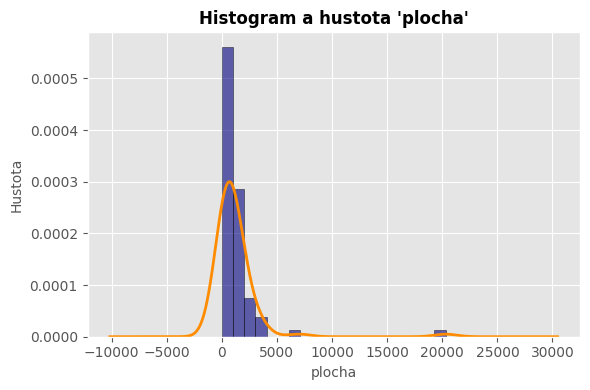

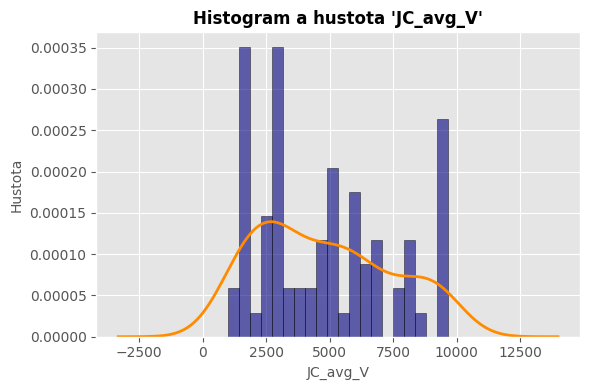

C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\124995264.py:85: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_time.resample('M').size()


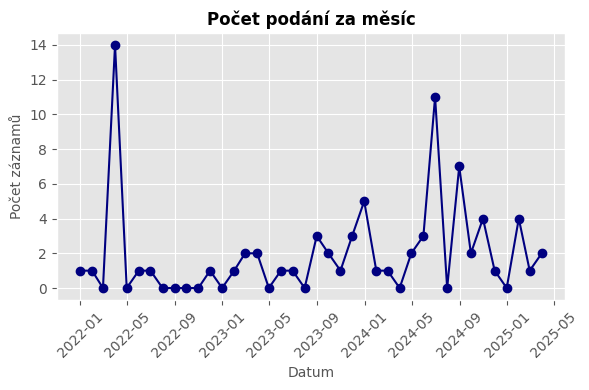

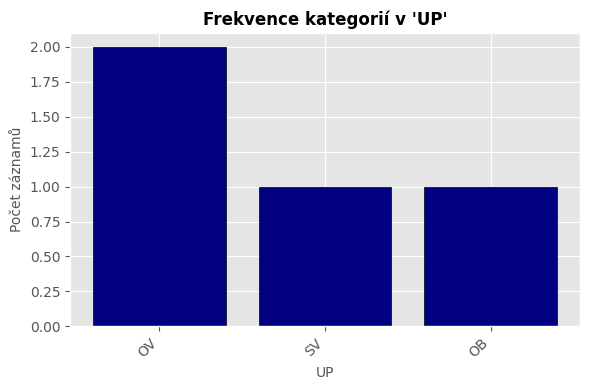

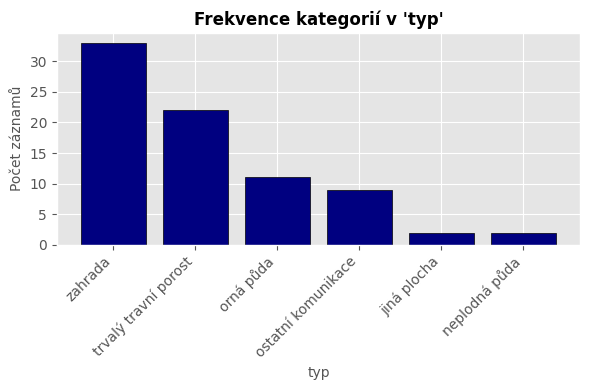


 AGREGOVANÉ STATISTIKY PODLE 'UP'


,count,mean_plocha,mean_JC,mean_datum
UP,,,,
OV,2,87.0,6096.5,2022-03-11 10:37:47
OB,1,387.0,1497.0,2024-06-13 11:35:40
SV,1,2287.0,6122.0,2022-11-03 11:20:18


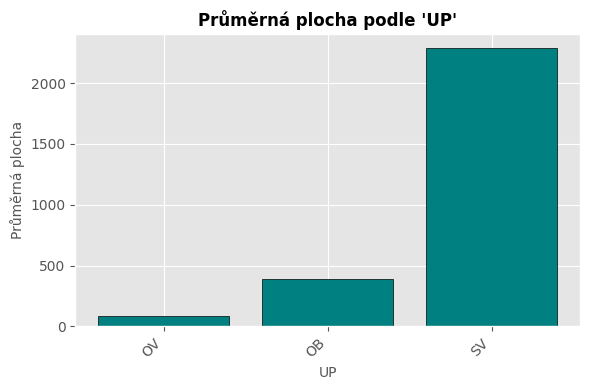

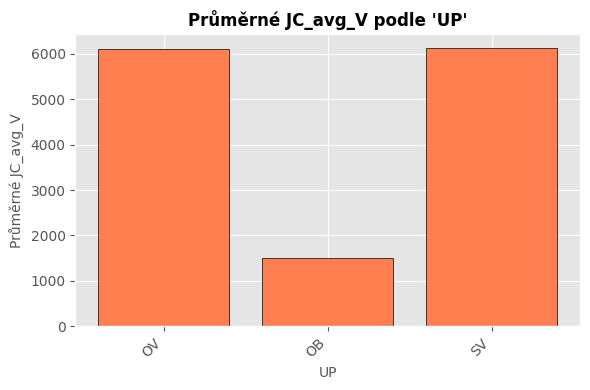

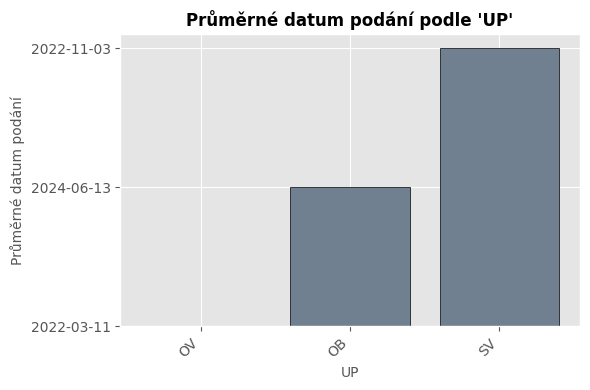

In [5]:
# *** 4 *** ZÁKLADNÍ STATISTIKY A HISTOGRAMY pres jednotlive parcely

import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------
# 1) Kontrola a převod 'datum_podani' na datetime
# ----------------------------------------------
if 'datum_podani' not in df_selected.columns:
    raise KeyError("Sloupec 'datum_podani' v DataFrame chybí.")

if not pd.api.types.is_datetime64_any_dtype(df_selected['datum_podani']):
    df_selected['datum_podani'] = pd.to_datetime(df_selected['datum_podani'], errors='coerce')

# ----------------------------------------------
# 2) Základní statistiky
# ----------------------------------------------
separator = "=" * 60

print(f"\n{separator}")
print(" ZÁKLADNÍ STATISTIKY NUMERICKÝCH SLOUPCŮ")
print(separator)
numeric_cols = ['plocha', 'JC_avg_V']
numeric_present = [col for col in numeric_cols if col in df_selected.columns]
if numeric_present:
    display(df_selected[numeric_present].describe().round(2))
else:
    print("Žádné z uvedených numerických sloupců ('plocha', 'JC_avg_V') nebyly nalezeny.")

print(f"\n{separator}")
print(" ZÁKLADNÍ STATISTIKY ČASOVÉ PROMĚNNÉ 'datum_podani'")
print(separator)
display(df_selected['datum_podani'].describe())

print(f"\n{separator}")
print(" FREKVENČNÍ ROZDĚLENÍ 'UP'")
print(separator)
if 'UP' in df_selected.columns:
    vc_up = df_selected['UP'].value_counts()
    display(vc_up.rename("count").to_frame())
else:
    print("Sloupec 'UP' neexistuje.")

print(f"\n{separator}")
print(" FREKVENČNÍ ROZDĚLENÍ 'typ'")
print(separator)
if 'typ' in df_selected.columns:
    vc_typ = df_selected['typ'].value_counts()
    display(vc_typ.rename("count").to_frame())
else:
    print("Sloupec 'typ' neexistuje.")

# ----------------------------------------------
# 3) Styl grafů
# ----------------------------------------------
if 'ggplot' in plt.style.available:
    plt.style.use('ggplot')

# ----------------------------------------------
# 4) Histogramy s hustotní křivkou (KDE) pro numerické sloupce
# ----------------------------------------------
for col in numeric_present:
    data = df_selected[col].dropna()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(data,
            bins=20,
            density=True,
            alpha=0.6,
            color='navy',
            edgecolor='black')
    data.plot.kde(ax=ax,
                  linewidth=2,
                  color='darkorange',
                  legend=False)
    ax.set_title(f"Histogram a hustota '{col}'", fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Hustota", fontsize=10)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------
# 5) Časová řada: počet podání za měsíc
# ----------------------------------------------
df_time = df_selected.set_index('datum_podani')
df_monthly = df_time.resample('M').size()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_monthly.index,
        df_monthly.values,
        marker='o',
        linestyle='-',
        color='navy')
ax.set_title("Počet podání za měsíc", fontsize=12, fontweight='bold')
ax.set_xlabel("Datum", fontsize=10)
ax.set_ylabel("Počet záznamů", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------------------------
# 6) Bar charty pro kategorické sloupce 'UP' a 'typ'
# ----------------------------------------------
categorical_cols = ['UP', 'typ']
for col in categorical_cols:
    if col in df_selected.columns:
        counts = df_selected[col].value_counts()
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(counts.index.astype(str),
               counts.values,
               color='navy',
               edgecolor='black')
        ax.set_title(f"Frekvence kategorií v '{col}'", fontsize=12, fontweight='bold')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel("Počet záznamů", fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Sloupec '{col}' chybí, bar chart přeskočen.")

# ----------------------------------------------
# 7) Agregované statistiky podle 'UP'
#    (průměr plochy, průměr JC_avg_V, průměr datum_podani)
# ----------------------------------------------
if 'UP' in df_selected.columns:
    cols_for_group = ['UP', 'plocha', 'JC_avg_V', 'datum_podani']
    df_tmp = df_selected[cols_for_group].copy()

    summary_up = (
        df_tmp
        .groupby('UP')
        .agg(
            count        = ('UP', 'size'),
            mean_plocha  = ('plocha', 'mean'),
            mean_JC      = ('JC_avg_V', 'mean'),
            mean_datum   = ('datum_podani', 'mean')
        )
        .sort_values(by='count', ascending=False)
    )

    summary_up['mean_plocha'] = summary_up['mean_plocha'].round(2)
    summary_up['mean_JC']     = summary_up['mean_JC'].round(2)

    print(f"\n{separator}")
    print(" AGREGOVANÉ STATISTIKY PODLE 'UP'")
    print(separator)
    display(summary_up)

    # ----------------------------------------------
    # 8) Graf průměrné plochy podle 'UP'
    # ----------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(summary_up.index.astype(str),
           summary_up['mean_plocha'],
           color='teal',
           edgecolor='black')
    ax.set_title("Průměrná plocha podle 'UP'", fontsize=12, fontweight='bold')
    ax.set_xlabel("UP", fontsize=10)
    ax.set_ylabel("Průměrná plocha", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------
    # 9) Graf průměrného JC_avg_V podle 'UP'
    # ----------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(summary_up.index.astype(str),
           summary_up['mean_JC'],
           color='coral',
           edgecolor='black')
    ax.set_title("Průměrné JC_avg_V podle 'UP'", fontsize=12, fontweight='bold')
    ax.set_xlabel("UP", fontsize=10)
    ax.set_ylabel("Průměrné JC_avg_V", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------
    # 10) Graf průměrného data podání podle 'UP'
    # ----------------------------------------------
    # Převod mean_datum na „jen datum“ formát pro lepší čitelnost
    mean_dates = summary_up['mean_datum'].dt.date

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(mean_dates.index.astype(str),
           mean_dates.values.astype(str),
           color='slategray',
           edgecolor='black')
    ax.set_title("Průměrné datum podání podle 'UP'", fontsize=12, fontweight='bold')
    ax.set_xlabel("UP", fontsize=10)
    ax.set_ylabel("Průměrné datum podání", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("Sloupec 'UP' neexistuje, nelze vypočítat agregované statistiky podle 'UP'.")



 ZÁKLADNÍ STATISTIKY NUMERICKÝCH SLOUPCŮ (po skupině cislo_vkladu)


,SUM_PARCEL_RIZENI,JC_avg_V
count,52.00,52.00
mean,1869.83,4998.90
std,3181.10,2389.09
min,3.00,1000.00
25%,681.25,3077.25
50%,1166.00,4958.50
75%,1514.50,6786.50
max,21485.00,9656.00



 ZÁKLADNÍ STATISTIKY ČASOVÉ PROMĚNNÉ 'datum_podani' (po skupině cislo_vkladu)


count                               52
mean     2023-11-21 12:14:45.115384320
min                2021-12-14 13:32:33
25%         2023-04-21 17:27:14.500000
50%         2023-12-21 01:26:37.500000
75%                2024-08-13 08:14:41
max                2025-03-19 09:00:00
Name: datum_podani, dtype: object


 FREKVENČNÍ ROZDĚLENÍ 'UP' (po skupině cislo_vkladu)


,count
UP,
,48
OV,2
SV,1
OB,1



 FREKVENČNÍ ROZDĚLENÍ 'typ' (po skupině cislo_vkladu)


,count
typ,
zahrada,24
trvalý travní porost,11
orná půda,7
"ostatní komunikace, trvalý travní porost",2
jiná plocha,2
"orná půda, zahrada",1
ostatní komunikace,1
"ostatní komunikace, trvalý travní porost, zahrada",1
"ostatní komunikace, zahrada",1


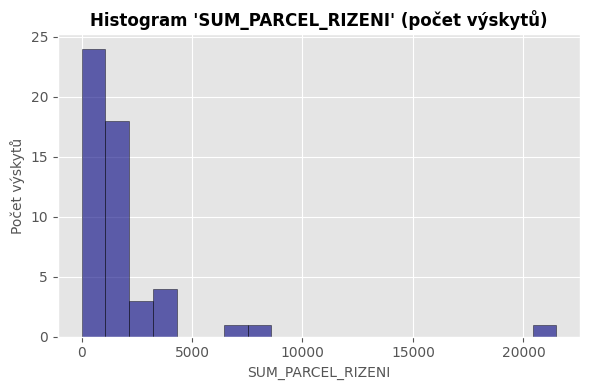

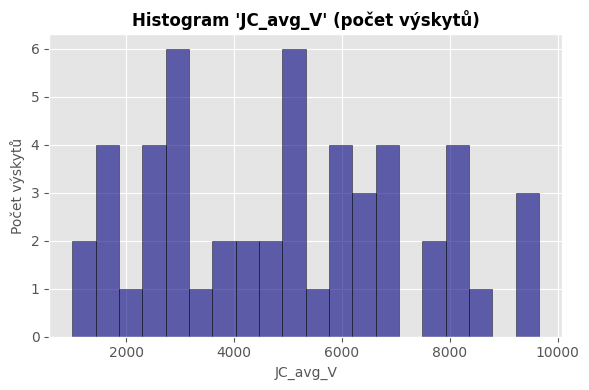

C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\1566497217.py:160: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_time.resample('M').size()


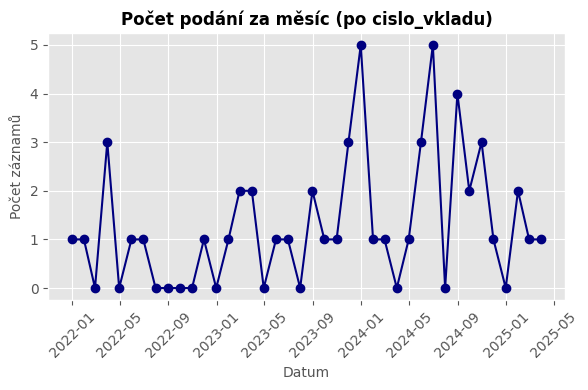

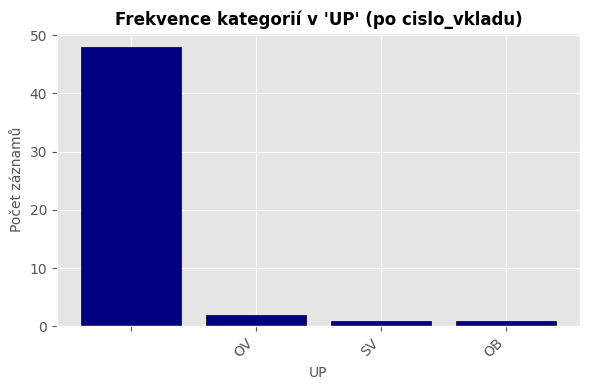

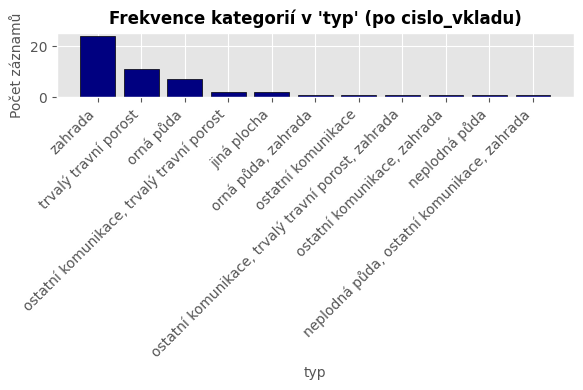


 AGREGOVANÉ STATISTIKY PODLE 'UP' (po cislo_vkladu)


,count,mean_plocha,mean_JC,mean_datum
UP,,,,
,48,1729.67,5002.73,2023-12-21 01:20:44.458333184
OV,2,3889.00,6096.50,2022-03-11 10:37:47.000000000
OB,1,4142.00,1497.00,2024-06-13 11:35:40.000000000
SV,1,2287.00,6122.00,2022-11-03 11:20:18.000000000


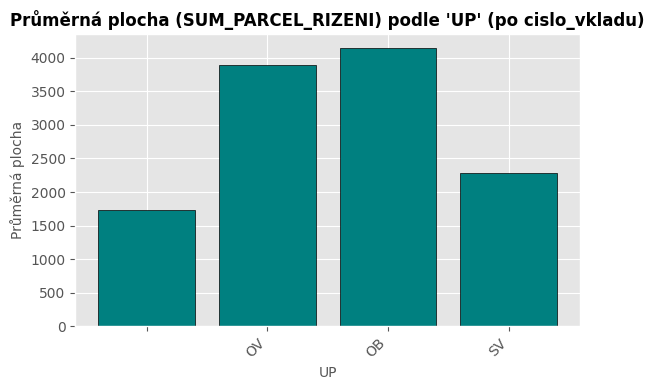

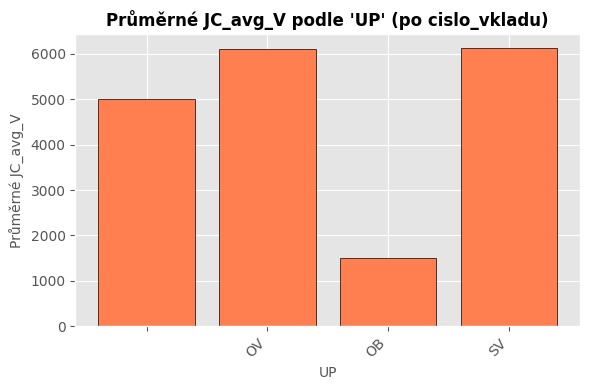

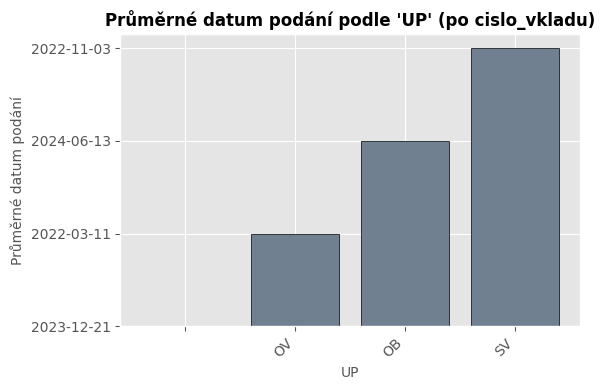

In [6]:
# *** 4a *** ZÁKLADNÍ STATISTIKY A HISTOGRAMY (Agregováno podle 'cislo_vkladu')


import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# PŘEDPOKLAD: df_selected obsahuje řádky s individuálními parcelami včetně sloupce 'SUM_PARCEL_RIZENI'
# ---------------------------------------------------------------------------

# ---------------------------------------------------------------------------
# 1) Agregace df_selected podle 'cislo_vkladu'
#    - 'rok', 'mesic', 'datum_podani', 'listina', '#PARCEL', 'SUM_PARCEL_RIZENI',
#      'okres', 'KU_Valuo', 'upper_zoning_id', 'lokalita', 'nemovitost' bereme jako první
#    - 'UP', 'typ' spojíme unikátní hodnoty jako řetězec
#    - 'cenovy_udaj' sečteme (celkový cenový údaj pro dané cislo_vkladu)
#    - 'SUM_PARCEL_RIZENI' sečteme (celková plocha ve sloupci SUM_PARCEL_RIZENI je již celkem; tzn. možemo použít 'first')
#      pokud se SUM_PARCEL_RIZENI liší v rámci parcel (např. duplicitní), bereme 'sum'
#    - 'JC_avg_V' zprůměrujeme (průměrná jednotková cena přes parcely jednoho cislo_vkladu)
# ---------------------------------------------------------------------------
agg_dict = {
    'rok':               'first',
    'mesic':             'first',
    'datum_podani':      'first',
    'listina':           'first',
    '#PARCEL':           'first',
    # Pokud SUM_PARCEL_RIZENI je stejné pro všechny řádky daného cislo_vkladu, můžeme použít 'first'.
    # Jinak použijeme 'sum', aby zohlednil případné rozdíly.
    'SUM_PARCEL_RIZENI': 'first',
    'okres':             'first',
    'KU_Valuo':          'first',
    'upper_zoning_id':   'first',
    'lokalita':          'first',
    'nemovitost':        'first',
    'cenovy_udaj':       'sum',
    'UP':                 lambda x: ', '.join(sorted(x.dropna().unique())),
    'typ':                lambda x: ', '.join(sorted(x.dropna().unique())),
    'JC_avg_V':           lambda x: x.mean()
}

df_agg = (
    df_selected
    .groupby('cislo_vkladu', as_index=False)
    .agg(agg_dict)
)

# Zaokrouhlení numerických sloupců
df_agg['SUM_PARCEL_RIZENI'] = df_agg['SUM_PARCEL_RIZENI'].round(2)
df_agg['cenovy_udaj'] = df_agg['cenovy_udaj'].round(2)
df_agg['JC_avg_V'] = df_agg['JC_avg_V'].round(2)

# ---------------------------------------------------------------------------
# 2) Připravíme df_group pro další výpočty
# ---------------------------------------------------------------------------
df_group = df_agg.copy()

# ---------------------------------------------------------------------------
# 3) Kontrola a převod 'datum_podani' na datetime
# ---------------------------------------------------------------------------
if 'datum_podani' not in df_group.columns:
    raise KeyError("Sloupec 'datum_podani' v agregovaném DataFrame chybí.")
if not pd.api.types.is_datetime64_any_dtype(df_group['datum_podani']):
    df_group['datum_podani'] = pd.to_datetime(df_group['datum_podani'], errors='coerce')

# ---------------------------------------------------------------------------
# 4) Základní statistiky (na agregovaných datech)
# ---------------------------------------------------------------------------
separator = "=" * 60

print(f"\n{separator}")
print(" ZÁKLADNÍ STATISTIKY NUMERICKÝCH SLOUPCŮ (po skupině cislo_vkladu)")
print(separator)
numeric_cols = ['SUM_PARCEL_RIZENI', 'JC_avg_V']
numeric_present = [col for col in numeric_cols if col in df_group.columns]
if numeric_present:
    display(df_group[numeric_present].describe().round(2))
else:
    print("Žádné z uvedených numerických sloupců ('SUM_PARCEL_RIZENI', 'JC_avg_V') nebyly nalezeny.")

print(f"\n{separator}")
print(" ZÁKLADNÍ STATISTIKY ČASOVÉ PROMĚNNÉ 'datum_podani' (po skupině cislo_vkladu)")
print(separator)
display(df_group['datum_podani'].describe())

print(f"\n{separator}")
print(" FREKVENČNÍ ROZDĚLENÍ 'UP' (po skupině cislo_vkladu)")
print(separator)
if 'UP' in df_group.columns:
    vc_up = df_group['UP'].value_counts()
    display(vc_up.rename("count").to_frame())
else:
    print("Sloupec 'UP' neexistuje.")

print(f"\n{separator}")
print(" FREKVENČNÍ ROZDĚLENÍ 'typ' (po skupině cislo_vkladu)")
print(separator)
if 'typ' in df_group.columns:
    vc_typ = df_group['typ'].value_counts()
    display(vc_typ.rename("count").to_frame())
else:
    print("Sloupec 'typ' neexistuje.")

# ---------------------------------------------------------------------------
# 5) Nastavení stylu grafů
# ---------------------------------------------------------------------------
if 'ggplot' in plt.style.available:
    plt.style.use('ggplot')

# ---------------------------------------------------------------------------
# 6) Histogramy s hustotní křivkou (KDE) pro numerické sloupce (agregovaná data)
# ---------------------------------------------------------------------------
""" for col in numeric_present:
    data = df_group[col].dropna()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(
        data,
        bins=20,
        density=True,
        alpha=0.6,
        color='navy',
        edgecolor='black'
    )
    data.plot.kde(
        ax=ax,
        linewidth=2,
        color='darkorange',
        legend=False
    )
    ax.set_title(f"Histogram a hustota '{col}' (po cislo_vkladu)", fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Hustota", fontsize=10)
    plt.tight_layout()
    plt.show()
 """

for col in numeric_present:
    data = df_group[col].dropna()
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # 1) Histogram s frekvencí na ose y (density=False)
    ax.hist(
        data,
        bins=20,
        density=False,       # zobrazí skutečný počet, nikoli hustotu
        alpha=0.6,
        color='navy',
        edgecolor='black'
    )
    
    ax.set_title(f"Histogram '{col}' (počet výskytů)", fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Počet výskytů", fontsize=10)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# 7) Časová řada: počet podání za měsíc (agregovaná data)
# ---------------------------------------------------------------------------
df_time = df_group.set_index('datum_podani')
df_monthly = df_time.resample('M').size()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    df_monthly.index,
    df_monthly.values,
    marker='o',
    linestyle='-',
    color='navy'
)
ax.set_title("Počet podání za měsíc (po cislo_vkladu)", fontsize=12, fontweight='bold')
ax.set_xlabel("Datum", fontsize=10)
ax.set_ylabel("Počet záznamů", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# 8) Bar charty pro kategorické sloupce 'UP' a 'typ' (agregovaná data)
# ---------------------------------------------------------------------------
categorical_cols = ['UP', 'typ']
for col in categorical_cols:
    if col in df_group.columns:
        counts = df_group[col].value_counts()
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(
            counts.index.astype(str),
            counts.values,
            color='navy',
            edgecolor='black'
        )
        ax.set_title(f"Frekvence kategorií v '{col}' (po cislo_vkladu)", fontsize=12, fontweight='bold')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel("Počet záznamů", fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Sloupec '{col}' chybí, bar chart přeskočen.")

# ---------------------------------------------------------------------------
# 9) Agregované statistiky podle 'UP' (po cislo_vkladu)
#    (průměr cenovej_udaj/SUM_PARCEL_RIZENI, průměr JC_avg_V, průměr datum)
# ---------------------------------------------------------------------------
if 'UP' in df_group.columns:
    cols_for_group = ['UP', 'SUM_PARCEL_RIZENI', 'JC_avg_V', 'datum_podani']
    df_tmp = df_group[cols_for_group].copy()

    summary_up = (
        df_tmp
        .groupby('UP')
        .agg(
            count         = ('UP', 'size'),
            mean_plocha   = ('SUM_PARCEL_RIZENI', 'mean'),
            mean_JC       = ('JC_avg_V', 'mean'),
            mean_datum    = ('datum_podani', 'mean')
        )
        .sort_values(by='count', ascending=False)
    )

    summary_up['mean_plocha'] = summary_up['mean_plocha'].round(2)
    summary_up['mean_JC']     = summary_up['mean_JC'].round(2)

    print(f"\n{separator}")
    print(" AGREGOVANÉ STATISTIKY PODLE 'UP' (po cislo_vkladu)")
    print(separator)
    display(summary_up)

    # Graf průměrné plochy podle 'UP'
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(
        summary_up.index.astype(str),
        summary_up['mean_plocha'],
        color='teal',
        edgecolor='black'
    )
    ax.set_title("Průměrná plocha (SUM_PARCEL_RIZENI) podle 'UP' (po cislo_vkladu)", fontsize=12, fontweight='bold')
    ax.set_xlabel("UP", fontsize=10)
    ax.set_ylabel("Průměrná plocha", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Graf průměrného JC_avg_V podle 'UP'
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(
        summary_up.index.astype(str),
        summary_up['mean_JC'],
        color='coral',
        edgecolor='black'
    )
    ax.set_title("Průměrné JC_avg_V podle 'UP' (po cislo_vkladu)", fontsize=12, fontweight='bold')
    ax.set_xlabel("UP", fontsize=10)
    ax.set_ylabel("Průměrné JC_avg_V", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Graf průměrného data podání podle 'UP'
    mean_dates = summary_up['mean_datum'].dt.date

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(
        mean_dates.index.astype(str),
        mean_dates.values.astype(str),
        color='slategray',
        edgecolor='black'
    )
    ax.set_title("Průměrné datum podání podle 'UP' (po cislo_vkladu)", fontsize=12, fontweight='bold')
    ax.set_xlabel("UP", fontsize=10)
    ax.set_ylabel("Průměrné datum podání", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Sloupec 'UP' neexistuje, nelze vypočítat agregované statistiky podle 'UP'.")


In [7]:
# *** 5 ***  Datasheets - HTML s mapou Folium pro každé číslo vkladu ***

import os
import shutil
import pandas as pd
import geopandas as gpd
import folium
from folium.elements import MacroElement
from folium.raster_layers import WmsTileLayer
from shapely.geometry import Polygon
from sqlalchemy import create_engine
import urllib.parse
from jinja2 import Template

# -------------------------------------------------------------------------
# Pomocné funkce a načtení dat
# -------------------------------------------------------------------------
def parse_geometry(geom_str):
    if geom_str is None or pd.isna(geom_str):
        return None
    try:
        coords = list(map(float, geom_str.split()))
        return Polygon([(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)])
    except Exception:
        return None

def format_thousand_space(val, decimals: int = 0) -> str:
    try:
        fval = float(val)
    except (ValueError, TypeError):
        return str(val)
    if fval.is_integer():
        s = f"{int(fval):,}"
        return s.replace(",", " ")
    s = f"{fval:,.{decimals}f}"
    return s.replace(",", " ").replace(".", ",")

def format_datum_podani(datum_str: str) -> str:
    try:
        dt = pd.to_datetime(datum_str)
        return dt.strftime("%d.%m.%Y %H:%M:%S")
    except Exception:
        return str(datum_str)

# -------------------------------------------------------------------------
# Připojení k databázi a načtení df_p
# -------------------------------------------------------------------------
conn = urllib.parse.quote_plus(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;Database=VALUO;Trusted_Connection=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn}")
df_p = pd.read_sql(query_pozemky, engine)
df_p['geometry'] = df_p['geometry'].apply(parse_geometry)

# Převod na GeoDataFrame a CRS→4326
gdf = gpd.GeoDataFrame(df_p, geometry='geometry', crs="EPSG:5514")
gdf = gdf.to_crs(epsg=4326)

# -------------------------------------------------------------------------
# 0) Připravíme si před samotnou smyčkou agregované pořadí (id) podle
#    nejnovějšího data_podani pro každé cislo_vkladu.
# -------------------------------------------------------------------------
# 0.1) Nejprve vytvoříme pomocný sloupec datum_parsed
gdf['datum_parsed'] = pd.to_datetime(gdf['datum_podani'], errors='coerce')

# 0.2) Seskupíme podle 'cislo_vkladu' a pro každou skupinu vezmeme nejnovější datum
df_ids = (
    gdf
    .groupby('cislo_vkladu', as_index=False)['datum_parsed']
    .agg('max')
)

# 0.3) Seřadíme výsledný DataFrame podle tohoto nejnovějšího data sestupně
df_ids = df_ids.sort_values(by='datum_parsed', ascending=False).reset_index(drop=True)

# 0.4) Přidáme sloupec 'id' na první pozici s číselným pořadím 1–N
df_ids.insert(0, 'id', range(1, len(df_ids) + 1))

# 0.5) Vytvoříme slovník pro rychlý lookup: cislo_vkladu → id
id_map = dict(zip(df_ids['cislo_vkladu'], df_ids['id']))

# -------------------------------------------------------------------------
# Vytvoření složek pro uložení výsledků
# -------------------------------------------------------------------------
output_dir = "datasheets_html"
maps_dir   = os.path.join(output_dir, "maps")
os.makedirs(maps_dir, exist_ok=True)

# -------------------------------------------------------------------------
# Smyčka – pro každé číslo vkladu vytvoříme 2 „varianty“ mapy a HTML
# -------------------------------------------------------------------------
for cislo_vkladu, group in gdf.groupby("cislo_vkladu"):
    group = group.copy()

    # ---------------------------------------------------------------------
    # Veškerá původní logika zpracování jedné skupiny zůstává, akorát si k ní
    # přidáme dříve spočtené ID pro 'cislo_vkladu'.
    # ---------------------------------------------------------------------

    # Převedeme 'datum_podani' na datetime pro řazení uvnitř skupiny
    group['datum_parsed'] = pd.to_datetime(group['datum_podani'], errors='coerce')
    # Seřadíme řádky dané skupiny sestupně podle 'datum_parsed'
    group = group.sort_values('datum_parsed', ascending=False)
    # Vezmeme první řádek (ten má nejnovější datum)
    prvni_radek = group.iloc[0]

    # ---------------------------------------------------------------------
    # 1) Připravíme header_info včetně požadovaných polí a přidáme sem i 'id'
    # ---------------------------------------------------------------------
    # Z lookup slovníku zjistíme ID pro toto číslo vkladu
    radek_id = id_map.get(cislo_vkladu, None)

    plne_datum = format_datum_podani(prvni_radek.get("datum_podani", ""))
    rok_mesic  = f"{prvni_radek.get('rok', '')}/{prvni_radek.get('mesic', '')}"

    # Cenový údaj (vezmeme z prvního řádku, přepočet EUR→CZK):
    raw_cena = float(prvni_radek.get("cenovy_udaj", 0) or 0)
    if prvni_radek.get("mena", "") == "EUR":
        raw_cena *= 25.0
    cena_str = format_thousand_space(raw_cena, decimals=0)

    header_info = {
        "ID (pořadí)": radek_id,
        "Číslo vkladu": cislo_vkladu,
        "Plné datum podání": plne_datum,
        "Rok / Měsíc": rok_mesic,
        "Počet pozemků v rámci řízení": len(group),
        "Celková plocha pozemků v rámci řízení (m²)": format_thousand_space(prvni_radek.get("SUM_PARCEL_RIZENI", 0)),
        "Cenový údaj (Kč)": cena_str,
        "Okres": prvni_radek.get("okres", ""),
        "K.území (Valuo)": prvni_radek.get("KU_Valuo", ""),
        "Kód k.území": prvni_radek.get("upper_zoning_id", ""),
        "Lokalita (administrativeUnit)": prvni_radek.get("lokalita", ""),
        "Nemovitost": prvni_radek.get("nemovitost", ""),
    }

    # ---------------------------------------------------------------------
    # 2) Připravíme data pro tabulku parcel (rozšířenou o Typ a UP,
    #    a místo celkové ceny použijeme cenu za každý dílčí pozemek = plocha × JC)
    # ---------------------------------------------------------------------
    parcel_rows = []
    for _, row in group.iterrows():
        parc_cislo = row.get("parcel_number", "")
        typ_parc   = row.get("typ", "")

        plocha_f = float(row.get("plocha", 0) or 0)
        plocha   = format_thousand_space(plocha_f, 0)

        jc_val = float(row.get("JC", 0) or 0)
        if row.get("mena", "") == "EUR":
            jc_val *= 25.0
        jc_str = format_thousand_space(jc_val, 0)

        cena_parc = plocha_f * jc_val
        cenova_str = format_thousand_space(cena_parc, 0)

        up_str = row.get("POPIS_Z", "")

        parcel_rows.append([
            parc_cislo,
            typ_parc,
            plocha,
            cenova_str,
            jc_str,
            up_str
        ])

    max_rows = 15
    rows_to_show = parcel_rows[:max_rows]
    if len(parcel_rows) > max_rows:
        rows_to_show.append(["...", "...", "...", "...", "...", "..."])

    # ---------------------------------------------------------------------
    # 3) Spočteme centroid pro výchozí pozici map
    # ---------------------------------------------------------------------
    centroidy = group.geometry.centroid
    center_lat = centroidy.y.mean()
    center_lon = centroidy.x.mean()

    # ==============================
    # 4.4.1) Vytvoření „horní mapy“ (m_top)
    # ==============================
    m_top = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=15,
        control_scale=True,
        tiles=None
    )

    # – OpenStreetMap, defaultně vypnutá:
    folium.TileLayer(
        tiles="OpenStreetMap",
        name="OpenStreetMap",
        attr="© OpenStreetMap contributors",
        control=True,
        show=False
    ).add_to(m_top)

    # – Ortofotomapa ČÚZK, defaultně zapnutá:
    folium.TileLayer(
        tiles='https://ags.cuzk.gov.cz/arcgis1/rest/services/ORTOFOTO_WM/MapServer/tile/{z}/{y}/{x}',
        name='Ortofotomapa ČÚZK',
        attr='© ČÚZK',
        overlay=False,
        control=True,
        show=True
    ).add_to(m_top)

    # – Ortofotomapa ESRI, defaultně vypnutá:
    folium.TileLayer(
        tiles="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="Ortofotomapa ESRI",
        attr="Esri World Imagery",
        control=True,
        show=False
    ).add_to(m_top)

    # – CartoDB LIGHT, vypnuté:
    folium.TileLayer(
        tiles="https://cartodb-basemaps-a.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png",
        name="CartoDB LIGHT",
        attr="© OpenStreetMap contributors © CARTO",
        control=True,
        show=False
    ).add_to(m_top)

    # – CartoDB DARK, vypnuté:
    folium.TileLayer(
        tiles="https://cartodb-basemaps-a.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png",
        name="CartoDB DARK",
        attr="© OpenStreetMap contributors © CARTO",
        control=True,
        show=False
    ).add_to(m_top)

    # – Katastrální mapa (KN) jako WMS, vypnutá:
    WmsTileLayer(
        url="https://services.cuzk.gov.cz/wms/local-km-wms.asp?",
        name="Katastrální mapa (KN)",
        layers="KN",
        fmt="image/png",
        transparent=True,
        version="1.3.0",
        attr="© ČÚZK",
        overlay=True,
        control=True,
        show=False,
        minZoom=0,
        maxZoom=30
    ).add_to(m_top)

    # Parcelní čísla od zoomu 16 (až budou dost čitelné)
    WmsTileLayer(
        url='https://services.cuzk.gov.cz/wms/local-km-wms.asp?',
        name='Parcelní čísla',
        layers='parcelni_cisla',
        fmt='image/png',
        transparent=True,
        version='1.3.0',
        attr='© ČÚZK',
        overlay=True,
        control=True,
        show=False,
        minZoom=0,
        maxZoom=30
    ).add_to(m_top)


    # – Územní plán Prahy (ArcGIS REST), vypnutý:
    class DynamicArcGISTileLayer(MacroElement):
        _template = Template(u"""
            {% macro script(this, kwargs) %}
                var DynamicLayer = L.TileLayer.extend({
                    getTileUrl: function(coords) {
                        var tileSize = 256;
                        var initialResolution = 2 * Math.PI * 6378137 / tileSize;
                        var originShift = 2 * Math.PI * 6378137 / 2.0;
                        var resolution = initialResolution / Math.pow(2, coords.z);
                        var minx = coords.x * tileSize * resolution - originShift;
                        var maxx = (coords.x + 1) * tileSize * resolution - originShift;
                        var miny = originShift - (coords.y + 1) * tileSize * resolution;
                        var maxy = originShift - coords.y * tileSize * resolution;
                        var bbox = [minx, miny, maxx, maxy].join(",");
                        return "{{ this.url }}?bbox=" + bbox +
                               "&bboxSR=102100&imageSR=102100&size=256,256" +
                               "&format=png32&transparent=true&layers=show:0&f=image";
                    }
                });
                var dynamicLayer = new DynamicLayer();
                dynamicLayer.addTo({{ this._parent.get_name() }});
            {% endmacro %}
        """)
        def __init__(self, url):
            super().__init__()
            self._name = "DynamicArcGISTileLayer"
            self.url = url

    arcgis_url = "https://gs-pub.praha.eu/arcgis/rest/services/pup/uzemni_plan_platny/MapServer/export"
    dynamic_fg = folium.FeatureGroup(
        name="Územní plán Prahy – plán využití",
        overlay=True, control=True, show=False
    )
    dynamic_fg.add_child(DynamicArcGISTileLayer(arcgis_url))
    m_top.add_child(dynamic_fg)

    # – Hranice parcel (GeoJson overlay)
    group_clean = group.drop(columns=["datum_parsed"], errors="ignore")
    group_clean = group_clean.loc[:, ~group_clean.columns.duplicated()]
    group_geom = gpd.GeoDataFrame(geometry=group_clean.geometry, crs=group_clean.crs)

    folium.GeoJson(
        group_geom,
        name="Parcely (modré hranice)",
        style_function=lambda feat: {
            "color": "blue",
            "weight": 5,
            "fill": True
        }
    ).add_to(m_top)

    # – Fit bounds
    bounds = group_geom.bounds
    minx, miny = bounds.minx.min(), bounds.miny.min()
    maxx, maxy = bounds.maxx.max(), bounds.maxy.max()
    m_top.fit_bounds([[miny, minx], [maxy, maxx]])

    # – LayerControl
    folium.LayerControl(collapsed=False).add_to(m_top)

    # Uložíme „horní“ mapu
    safe_cislo = str(cislo_vkladu).replace("/", "_").replace(" ", "_")
    map_top_filename = f"map_top_{safe_cislo}.html"
    map_top_path     = os.path.join(maps_dir, map_top_filename)
    m_top.save(map_top_path)

    # ==============================
    # 4.4.2) Vytvoření „spodní mapy“ (m_bottom) s jinými defaulty
    # ==============================
    m_bottom = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=15,
        control_scale=True,
        tiles=None
    )

    # – OpenStreetMap, defaultně vypnutá:
    folium.TileLayer(
        tiles="OpenStreetMap",
        name="OpenStreetMap",
        attr="© OpenStreetMap contributors",
        control=True,
        show=False
    ).add_to(m_bottom)

    # – Ortofotomapa ČÚZK, vypnutá:
    folium.TileLayer(
        tiles='https://ags.cuzk.gov.cz/arcgis1/rest/services/ORTOFOTO_WM/MapServer/tile/{z}/{y}/{x}',
        name='Ortofotomapa ČÚZK',
        attr='© ČÚZK',
        overlay=False,
        control=True,
        show=False
    ).add_to(m_bottom)

    # – Ortofotomapa ESRI, vypnutá:
    folium.TileLayer(
        tiles="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="Ortofotomapa ESRI",
        attr="Esri World Imagery",
        control=True,
        show=False
    ).add_to(m_bottom)

    # – CartoDB LIGHT, vypnuté:
    folium.TileLayer(
        tiles="https://cartodb-basemaps-a.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png",
        name="CartoDB LIGHT",
        attr="© OpenStreetMap contributors © CARTO",
        control=True,
        show=False
    ).add_to(m_bottom)

    # – CartoDB DARK, vypnuté:
    folium.TileLayer(
        tiles="https://cartodb-basemaps-a.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png",
        name="CartoDB DARK",
        attr="© OpenStreetMap contributors © CARTO",
        control=True,
        show=False
    ).add_to(m_bottom)

    # – Katastrální mapa (KN) jako WMS, vypnutá:
    WmsTileLayer(
        url="https://services.cuzk.gov.cz/wms/local-km-wms.asp?",
        name="Katastrální mapa (KN)",
        layers="KN",
        fmt="image/png",
        transparent=True,
        version="1.3.0",
        attr="© ČÚZK",
        overlay=True,
        control=True,
        show=False,
        minZoom=0,
        maxZoom=30
    ).add_to(m_bottom)


    # Parcelní čísla od zoomu 16 (až budou dost čitelné)
    WmsTileLayer(
        url='https://services.cuzk.gov.cz/wms/local-km-wms.asp?',
        name='Parcelní čísla',
        layers='parcelni_cisla',
        fmt='image/png',
        transparent=True,
        version='1.3.0',
        attr='© ČÚZK',
        overlay=True,
        control=True,
        show=False,
        minZoom=0,
        maxZoom=30
    ).add_to(m_bottom)

    # – Územní plán Prahy, defaultně ZAPNUTÝ:
    dynamic_fg2 = folium.FeatureGroup(
        name="Územní plán Prahy – plán využití",
        overlay=True, control=True, show=True
    )
    dynamic_fg2.add_child(DynamicArcGISTileLayer(arcgis_url))
    m_bottom.add_child(dynamic_fg2)

    # – Hranice parcel (modré hranice)
    folium.GeoJson(
        group_geom,
        name="Parcely (modré hranice)",
        style_function=lambda feat: {
            "color": "blue",
            "weight": 5,
            "fill": True
        }
    ).add_to(m_bottom)

    # – Fit bounds
    m_bottom.fit_bounds([[miny, minx], [maxy, maxx]])

    # – LayerControl
    folium.LayerControl(collapsed=False).add_to(m_bottom)

    # Uložíme „spodní“ mapu
    map_bottom_filename = f"map_bottom_{safe_cislo}.html"
    map_bottom_path     = os.path.join(maps_dir, map_bottom_filename)
    m_bottom.save(map_bottom_path)

    # -----------------------------------------------------------
    # 4.5) Vytvoření wrapper‐HTML "datasheet_{cislo_vkladu}.html"
    #      – levá část = text + tabulka, pravá část = dvě iframy
    # -----------------------------------------------------------
    html_head = f"""
    <!DOCTYPE html>
    <html lang="cs">
    <head>
      <meta charset="UTF-8" />
      <title>Datasheet {cislo_vkladu}</title>
      <style>
        body {{
          font-family: Arial, sans-serif;
          margin: 0;
          padding: 0;
        }}
        .container {{
          display: flex;
          flex-direction: row;
          width: 100vw;
          height: 100vh;
        }}
        .left-panel {{
          width: 50%;
          padding: 20px;
          box-sizing: border-box;
          overflow-y: auto;
        }}
        .right-panel {{
          width: 50%;
          display: flex;
          flex-direction: column;
          position: relative;
        }}
        .info-item {{
          margin-bottom: 8px;
        }}
        h2 {{
          margin-top: 0;
          font-size: 1.4em;
        }}
        table {{
          border-collapse: collapse;
          width: 100%;
          margin-top: 20px;
        }}
        table, th, td {{
          border: 1px solid #333;
        }}
        th, td {{
          padding: 6px 8px;
          text-align: center;
        }}
        th {{
          background-color: #f2f2f2;
        }}
        .iframe-container {{
          width: 100%;
          border: none;
        }}
        .iframe-top {{
          flex: 1;
        }}
        .iframe-bottom {{
          flex: 1;
        }}
      </style>
    </head>
    <body>
      <div class="container">
        <div class="left-panel">
          <!-- NÁZEV NADPISU: ID + ČÍSLO VKLADU -->
          <h2>Datasheet – ID: {header_info["ID (pořadí)"]} | Číslo vkladu: {cislo_vkladu}</h2>

          <!-- BLOK 1: DATUM PODÁNÍ -->
          <div class="info-item"><strong>Datum podání:</strong> {header_info["Plné datum podání"]}</div>
          <div class="info-item"><strong>Rok / Měsíc:</strong> {header_info["Rok / Měsíc"]}</div>
          <div style="height:12px;"></div>  <!-- mezera -->

          <!-- BLOK 2: POČET A PLOCHA -->
          <div class="info-item"><strong>Počet pozemků v rámci řízení:</strong> {header_info["Počet pozemků v rámci řízení"]}</div>
          <div class="info-item"><strong style="color: green;">Celková plocha pozemků v rámci řízení (m²):<b> {header_info["Celková plocha pozemků v rámci řízení (m²)"]}</b></strong></div>
          <div style="height:12px;"></div>  <!-- mezera -->

          <!-- BLOK 3: CENOVÝ ÚDAJ -->
          <div class="info-item"><strong style="color: blue;">Cenový údaj (Kč):<b> {header_info["Cenový údaj (Kč)"]}</b></strong></div>
          <div style="height:12px;"></div>  <!-- mezera -->

          <!-- BLOK 4: LOKALIZAČNÍ ÚDAJE -->
          <div class="info-item"><strong>Okres:</strong> {header_info["Okres"]}</div>
          <div class="info-item"><strong>Kat.území:</strong> {header_info["K.území (Valuo)"]}</div>
          <div class="info-item"><strong>Kód kat.území:</strong> {header_info["Kód k.území"]}</div>
          <div class="info-item"><strong>Lokalita (administrativeUnit):</strong> {header_info["Lokalita (administrativeUnit)"]}</div>
          <div class="info-item"><strong>Nemovitost - druh:</strong> {header_info["Nemovitost"]}</div>

          <!-- TABULKA PARCEL (rozšířená o Typ a UP) -->
          <table>
            <tr>
              <th>Parcelní číslo</th>
              <th>Typ parcely</th>
              <th>Plocha (m²)</th>
              <th>Cena (Kč)</th>
              <th>JC avg(Kč/m²)</th>
              <th>UP (převažující funkční využití)</th>
            </tr>
    """

    # Přidání řádků do tabulky
    table_rows_html = ""
    for row_data in rows_to_show:
        table_rows_html += "<tr>" + "".join(f"<td>{cell}</td>" for cell in row_data) + "</tr>\n"

    if len(parcel_rows) > max_rows:
        table_rows_html += """
        <tr><td colspan="6" style="color:red;">Tabulka je oříznuta (více než 15 parcel).</td></tr>
        """

    html_mid = f"""
          {table_rows_html}
          </table>
        </div>  <!-- end left-panel -->
        <div class="right-panel">
          <iframe class="iframe-container iframe-top"    src="maps/{map_top_filename}"></iframe>
          <iframe class="iframe-container iframe-bottom" src="maps/{map_bottom_filename}"></iframe>
        </div>  <!-- end right-panel -->
      </div>  <!-- end container -->
    </body>
    </html>
    """

    # Uložení wrapper‐HTML
    safe_cislo = str(radek_id) + '-' + str(cislo_vkladu).replace("/", "_").replace(" ", "_")
    kryci_list_filename = f"datasheet_{safe_cislo}.html"
    kryci_list_path = os.path.join(output_dir, kryci_list_filename)
    with open(kryci_list_path, "w", encoding="utf-8") as f:
        f.write(html_head + html_mid)

    print(f"Vygenerováno: {kryci_list_filename}")

print("\nHotovo! Všechny datasheety v HTML formátu jsou ve složce:", output_dir)


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_12-V-10282_2024-209.html
Vygenerováno: datasheet_11-V-10462_2024-209.html
Vygenerováno: datasheet_35-V-10840_2023-209.html
Vygenerováno: datasheet_9-V-11472_2024-209.html
Vygenerováno: datasheet_8-V-11871_2024-209.html
Vygenerováno: datasheet_34-V-11949_2023-209.html
Vygenerováno: datasheet_33-V-12419_2023-209.html
Vygenerováno: datasheet_32-V-12592_2023-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_7-V-13107_2024-209.html
Vygenerováno: datasheet_6-V-13216_2024-209.html
Vygenerováno: datasheet_5-V-13432_2024-209.html
Vygenerováno: datasheet_2-V-1370_2025-209.html
Vygenerováno: datasheet_30-V-13792_2023-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_28-V-14272_2023-209.html
Vygenerováno: datasheet_45-V-14475_2022-209.html
Vygenerováno: datasheet_27-V-14475_2023-209.html
Vygenerováno: datasheet_26-V-14734_2023-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_43-V-1509_2023-209.html
Vygenerováno: datasheet_52-V-20021_2021-209.html
Vygenerováno: datasheet_42-V-2056_2023-209.html
Vygenerováno: datasheet_41-V-2373_2023-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_40-V-2860_2023-209.html
Vygenerováno: datasheet_50-V-3065_2022-209.html
Vygenerováno: datasheet_1-V-3408_2025-209.html
Vygenerováno: datasheet_49-V-3520_2022-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_48-V-3524_2022-209.html
Vygenerováno: datasheet_21-V-3805_2024-201.html
Vygenerováno: datasheet_44-V-389_2023-209.html
Vygenerováno: datasheet_4-V-431_2025-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_23-V-4446_2024-209.html
Vygenerováno: datasheet_19-V-4514_2024-201.html
Vygenerováno: datasheet_38-V-4676_2023-201.html
Vygenerováno: datasheet_39-V-4962_2023-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_22-V-5025_2024-209.html
Vygenerováno: datasheet_20-V-5555_2024-209.html
Vygenerováno: datasheet_3-V-583_2025-209.html
Vygenerováno: datasheet_25-V-606_2024-201.html
Vygenerováno: datasheet_18-V-7032_2024-209.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_17-V-7063_2024-209.html
Vygenerováno: datasheet_10-V-7107_2024-201.html
Vygenerováno: datasheet_16-V-7112_2024-209.html
Vygenerováno: datasheet_47-V-7532_2022-209.html
Vygenerováno: datasheet_15-V-7784_2024-209.html
Vygenerováno: datasheet_46-V-7911_2022-209.html
Vygenerováno: datasheet_24-V-860_2024-201.html
Vygenerováno: datasheet_37-V-8714_2023-209.html
Vygenerováno: datasheet_31-V-8798_2023-201.html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results f

Vygenerováno: datasheet_51-V-903_2022-209.html
Vygenerováno: datasheet_36-V-9091_2023-209.html
Vygenerováno: datasheet_29-V-9138_2023-201.html
Vygenerováno: datasheet_14-V-9676_2024-209.html
Vygenerováno: datasheet_13-V-9889_2024-209.html

Hotovo! Všechny datasheety v HTML formátu jsou ve složce: datasheets_html


C:\Users\ijttr\AppData\Local\Temp\ipykernel_52340\3444228841.py:177: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroidy = group.geometry.centroid
